<a href="https://colab.research.google.com/github/KaMeLoTmArMoT/TACOTRON-2/blob/main/Taco_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Avialable models and ids (first letter - train samples, second - batch size):

---

alex 120_8:
1lyo91yhMNQXvt00_5Xel7EwoDc14II7w

alex 80_8:
14g7b9xlB0xx5dbuzZHmzrzqveXqJYKHT

alex 80_4:
1NSf-dSAfdOSw5-CT1TGQ7zP3VVLPH60c

alex 60:
1otmPxRPpupN4WjYICn0DN2XFISX8bqd1

alex 40:
1ZQ2GnEpwZJXfCca_UQlVkuSXH1V-7GHP

andrii 67_5:
1MwYBb5a9rqtrXDvHVDFgROlyINLtEhhO

---

FastPitch aligns input symbols to output mel-spectrogram frames automatically and does not rely on any external aligning model. FastPitch training can be started on raw waveforms without any pre-processing: pitch values and mel-spectrograms will be calculated on-line.

For every mel-spectrogram frame, its fundamental frequency in Hz is estimated with the Probabilistic YIN algorithm.

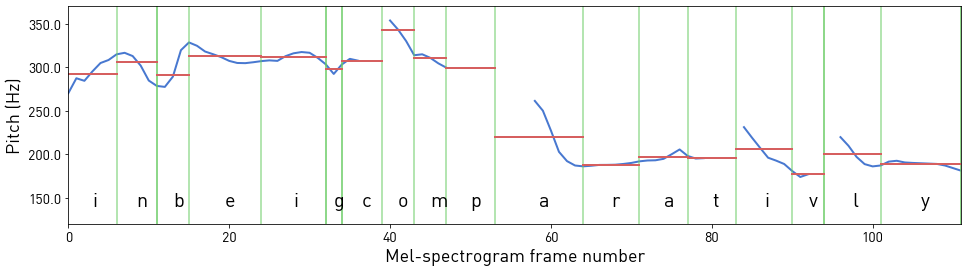

In [ ]:
#@title Init all {display-mode: "form"}

import os

if not os.path.exists('MLPTTS'):

  %tensorflow_version 1.x
  %matplotlib inline
  !pip install tqdm -q
  !pip install gdown

  import sys
  import time
  import matplotlib
  import matplotlib.pylab as plt
  import gdown
  import IPython.display as ipd
  import numpy as np
  import torch
  import json
  from IPython.display import clear_output
  from os.path import exists, join, basename, splitext
  from tqdm.notebook import tqdm

  git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
  project_name = splitext(basename(git_repo_url))[0]

  !git clone -q --recursive {git_repo_url}
  !git clone -q --recursive https://github.com/SortAnon/hifi-gan
  !pip install -q librosa unidecode

  sys.path.append('hifi-gan')
  sys.path.append(project_name)
      
  from hparams import create_hparams
  from model import Tacotron2
  from layers import TacotronSTFT
  from audio_processing import griffin_lim
  from text import text_to_sequence
  from env import AttrDict
  from meldataset import MAX_WAV_VALUE
  from models import Generator

  HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

  d = 'https://drive.google.com/uc?id='

  # Setup Pronounciation Dictionary
  !gdown --id '1IUxCkgRNsoDCLtMZxYXmIePAKgh0m-aZ'
  thisdict = {}
  for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
    thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

  graph_width = 900
  graph_height = 360

  previous_tt2_id = ''
  previous_tt2_id_2 = ''
  previous_gan = ''
  # end of predefined and download.

def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
      axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                  interpolation='none', cmap='inferno')
  fig.canvas.draw()
  plt.show()

def get_hifigan(MODEL_ID):
  # Download HiFi-GAN
  hifigan_pretrained_model = 'hifimodel'
  gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
  if not exists(hifigan_pretrained_model):
      raise Exception("HiFI-GAN model failed to download!")
  # Load HiFi-GAN
  conf = os.path.join("hifi-gan", "config_v1.json")
  with open(conf) as f:
      json_config = json.loads(f.read())
  h = AttrDict(json_config)
  torch.manual_seed(h.seed)
  hifigan = Generator(h).to(torch.device("cuda"))
  state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
  hifigan.load_state_dict(state_dict_g["generator"])
  hifigan.eval()
  hifigan.remove_weight_norm()
  return hifigan, h

def has_MMI(STATE_DICT):
  return any(True for x in STATE_DICT.keys() if "mi." in x)

def get_Tactron2(MODEL_ID):
  # Download Tacotron2
  tacotron2_pretrained_model = 'MLPTTS'
  gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
  if not exists(tacotron2_pretrained_model):
      raise Exception("Tacotron2 model failed to download!")
  # Load Tacotron2 and Config
  hparams = create_hparams()
  hparams.sampling_rate = 22050
  hparams.max_decoder_steps = 3000 # Max Duration
  hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
  model = Tacotron2(hparams)
  state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
  if has_MMI(state_dict):
      raise Exception("ERROR: This notebook does not currently support MMI models.")
  model.load_state_dict(state_dict)
  _ = model.cuda().eval().half()
  return model, hparams

def get_model_id(name):
  models = {
      'alex 120_8': '1lyo91yhMNQXvt00_5Xel7EwoDc14II7w',
      'alex 80_8': '14g7b9xlB0xx5dbuzZHmzrzqveXqJYKHT',
      'alex 80_4': '1NSf-dSAfdOSw5-CT1TGQ7zP3VVLPH60c',
      'alex 60': '1otmPxRPpupN4WjYICn0DN2XFISX8bqd1',
      'alex 40': '1ZQ2GnEpwZJXfCca_UQlVkuSXH1V-7GHP',
      'andrii 67_5': '1MwYBb5a9rqtrXDvHVDFgROlyINLtEhhO'
  }
  return models.get(name)

def get_waveglow():
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='int16')
  waveglow = waveglow.remove_weightnorm(waveglow)
  waveglow = waveglow.to('cuda')
  waveglow.eval().half()
  return waveglow

def infer(taco_model, sequence):
  mel_outputs, mel_outputs_postnet, _, alignments = taco_model.inference(sequence)
  plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
            alignments.float().data.cpu().numpy()[0].T))
  
  if model_name_3 == "hifigan":
    y_g_hat = gan(mel_outputs_postnet.float())
  else:
    y_g_hat = gan.infer(mel_outputs_postnet)
  
  audio = y_g_hat.squeeze()
  audio = audio * MAX_WAV_VALUE
  ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))

def end_to_end_infer(text):
  for i in [x for x in text.split("\n") if len(x)]:
    
    if i[-1] != ";": i=i+";"
    
    %matplotlib inline
    with torch.no_grad(): # save VRAM by not including gradients
      sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
      sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
      
      infer(model, sequence)
      
      if model_name_2 != "none":
        infer(model_2, sequence)

clear_output()

In [ ]:
model_name_1 = "alex 120_8"  #@param ['alex 120_8', 'alex 80_8', 'alex 80_4', 'alex 60', 'alex 40', 'andrii 67_5']
model_name_2 = "andrii 67_5"  #@param ['none', 'alex 120_8', 'alex 80_8', 'alex 80_4', 'alex 60', 'alex 40', 'andrii 67_5']
model_name_3 = "hifigan"  #@param ['hifigan', 'waveglow']
steps = 1000 #@param {type:"integer"}
stop_threshold = 0.25 #@param {type:"number"}

Tacotron_model = get_model_id(model_name_1)
TACOTRON2_ID = Tacotron_model

if model_name_2 != 'none':
  Tacotron_model_2 = get_model_id(model_name_2)
  TACOTRON2_ID_2 = Tacotron_model_2


if previous_gan != model_name_3:
  if model_name_3 == 'hifigan':
    gan, h = get_hifigan(HIFIGAN_ID)
  else:
    gan = get_waveglow()
  
  previous_gan = model_name_3

if previous_tt2_id != TACOTRON2_ID:
  print("Updating Model 1")
  model, hparams = get_Tactron2(TACOTRON2_ID)
  model.decoder.max_decoder_steps = steps
  model.decoder.gate_threshold = stop_threshold
  previous_tt2_id = TACOTRON2_ID

if model_name_2 != 'none' and previous_tt2_id_2 != TACOTRON2_ID_2:
  print("Updating Model 2")
  model_2, hparams_2 = get_Tactron2(TACOTRON2_ID_2)
  model_2.decoder.max_decoder_steps = steps
  model_2.decoder.gate_threshold = stop_threshold
  previous_tt2_id_2 = TACOTRON2_ID_2

clear_output()

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        # clear_output()
        print(line)
        if line == "":
            continue
        end_to_end_infer(line)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break